In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.svm import SVC



In [2]:
file_path = "Healthcare-Diabetes.csv"
df = pd.read_csv(file_path)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())
print("\nValue counts (Outcome):\n", df['Outcome'].value_counts())


Shape: (2768, 10)
Columns: ['Id', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1



Value counts (Outcome):
 Outcome
0    1816
1     952
Name: count, dtype: int64


In [3]:
# Preprocessing
# Drop Id if present
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

# Define X and y
target_col = 'Outcome'
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Columns where 0 means missing in Pima-style datasets
cols_zero_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
cols_zero_missing = [c for c in cols_zero_missing if c in X.columns]

# Replace zeros with NaN for these columns
for c in cols_zero_missing:
    X[c] = X[c].replace(0, np.nan)

print("\nMissing counts after zero->NaN replacement:")
print(X.isnull().sum())

# Median imputation
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Feature scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)



Missing counts after zero->NaN replacement:
Pregnancies                    0
Glucose                       18
BloodPressure                125
SkinThickness                800
Insulin                     1330
BMI                           39
DiabetesPedigreeFunction       0
Age                            0
dtype: int64


In [4]:
# Feature selection (SelectKBest)
k = min(6, X_scaled.shape[1])  # top 6 features (adjust k as desired)
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled, y)
mask = selector.get_support()
selected_features = X_scaled.columns[mask].tolist()
feature_scores = pd.DataFrame({'feature': X_scaled.columns, 'score': selector.scores_}).sort_values(by='score', ascending=False)
print("\nFeature ranking (top scores):")
display(feature_scores.head(10))
print("\nSelected top-{} features: {}".format(k, selected_features))

X_sel_df = pd.DataFrame(X_selected, columns=selected_features)



Feature ranking (top scores):


,feature,score
1,Glucose,869.614219
5,BMI,254.370540
7,Age,164.682499
0,Pregnancies,145.838184
3,SkinThickness,124.254769
4,Insulin,114.537627
2,BloodPressure,84.126010
6,DiabetesPedigreeFunction,73.290048



Selected top-6 features: ['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'Age']


Correlation matrix (features + Outcome):
                Pregnancies   Glucose  SkinThickness   Insulin       BMI  \
Pregnancies       1.000000  0.123436       0.084142  0.025340  0.013907   
Glucose           0.123436  1.000000       0.203349  0.410528  0.232277   
SkinThickness     0.084142  0.203349       1.000000  0.172661  0.525719   
Insulin           0.025340  0.410528       0.172661  1.000000  0.196762   
BMI               0.013907  0.232277       0.525719  0.196762  1.000000   
Age               0.540805  0.261941       0.128470  0.064960  0.020426   
Outcome           0.223796  0.489074       0.207343  0.199406  0.290204   

                    Age   Outcome  
Pregnancies    0.540805  0.223796  
Glucose        0.261941  0.489074  
SkinThickness  0.128470  0.207343  
Insulin        0.064960  0.199406  
BMI            0.020426  0.290204  
Age            1.000000  0.237050  
Outcome        0.237050  1.000000  


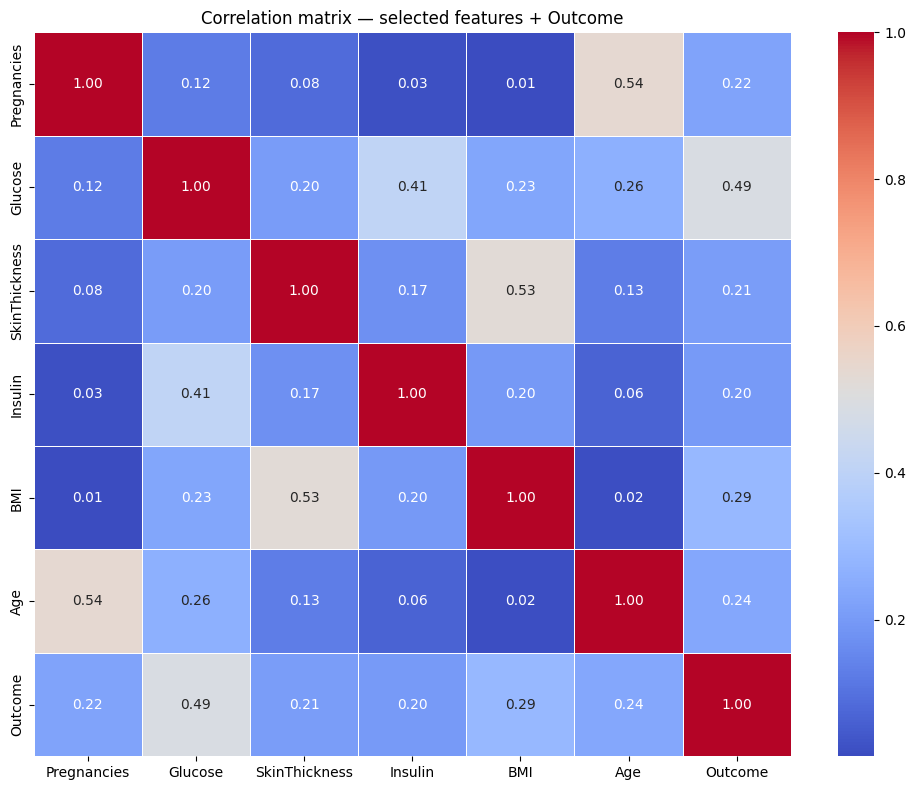

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 1) Correlation matrix (features + target)
corr_df = pd.concat([X_sel_df.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
corr_matrix = corr_df.corr()

print("Correlation matrix (features + Outcome):\n", corr_matrix)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation matrix — selected features + Outcome")
plt.tight_layout()
plt.show()

In [11]:
# 2) Linear Regression (using selected features). If X_sel_df / y already split in notebook, override split for regression clarity.
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_sel_df, y, test_size=0.2, stratify=y, random_state=42
)

lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)

y_pred_lr = lr.predict(X_test_lr)

# Continuous evaluation
mse = mean_squared_error(y_test_lr, y_pred_lr)
r2 = r2_score(y_test_lr, y_pred_lr)
print("\n--- Linear Regression (Continuous Evaluation) ---")
print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.6f}")



--- Linear Regression (Continuous Evaluation) ---
Mean Squared Error: 0.164736
R² Score: 0.270763


In [12]:
# Classification Metrics (Threshold = 0.5)
y_pred_class = (y_pred_lr >= 0.5).astype(int)

acc = accuracy_score(y_test_lr, y_pred_class)
prec = precision_score(y_test_lr, y_pred_class)
rec = recall_score(y_test_lr, y_pred_class)
f1 = f1_score(y_test_lr, y_pred_class)
roc_auc = roc_auc_score(y_test_lr, y_pred_lr)

print("\n--- Classification Metrics (Threshold = 0.5) ---")
print(f"Accuracy Score     : {acc:.4f}")
print(f"Precision Score    : {prec:.4f}")
print(f"Recall Score       : {rec:.4f}")
print(f"F1 Score           : {f1:.4f}")
print(f"ROC-AUC Score      : {roc_auc:.4f}")



--- Classification Metrics (Threshold = 0.5) ---
Accuracy Score     : 0.7473
Precision Score    : 0.6689
Recall Score       : 0.5288
F1 Score           : 0.5906
ROC-AUC Score      : 0.8201


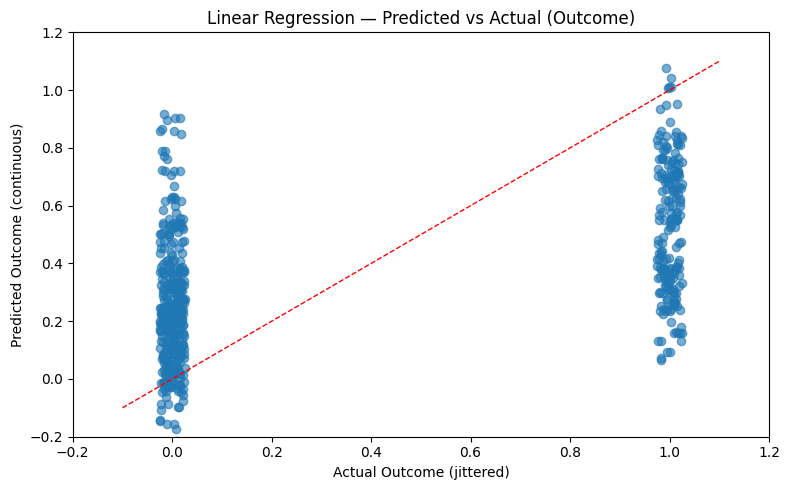

In [13]:
# Predicted vs Actual (with jitter on actual for visibility)
plt.figure(figsize=(8,5))
# jitter actuals slightly for visualization
jitter = (np.random.rand(len(y_test_lr)) - 0.5) * 0.05
plt.scatter(y_test_lr + jitter, y_pred_lr, alpha=0.6)
plt.xlabel("Actual Outcome (jittered)")
plt.ylabel("Predicted Outcome (continuous)")
plt.title("Linear Regression — Predicted vs Actual (Outcome)")
plt.plot([ -0.1, 1.1 ], [ -0.1, 1.1 ], 'r--', linewidth=1)  # reference diagonal
plt.ylim(-0.2, 1.2)
plt.xlim(-0.2, 1.2)
plt.tight_layout()
plt.show()

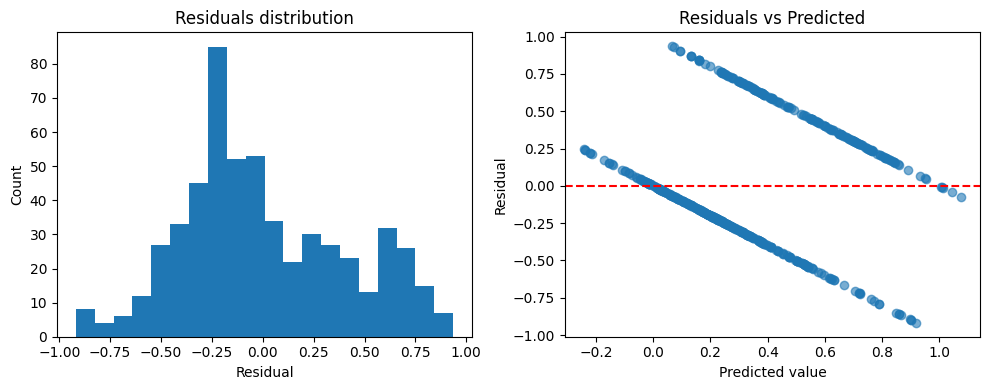

In [14]:
# Residuals histogram + residuals vs predicted
residuals = y_test_lr - y_pred_lr

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(residuals, bins=20)
plt.title("Residuals distribution")
plt.xlabel("Residual")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()